# Binary segmentation with the Lovász Hinge
## Tensorflow version, see PyTorch version for more details & use in training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

In [3]:
import sys

In [4]:
import tensorflow as tf

In [5]:
import lovasz_losses_tf as L

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# add parent path to pythonpath to import demo_utils
import sys
sys.path.append('../demo_helpers')
from demo_utils import pil_grid, dummy_triangles
from demo_utils_tf import define_scope

In [8]:
# add pytorch folder to path for comparison
sys.path.append('../pytorch')
import lovasz_losses as L_pytorch

### Ground truth

In [9]:
H = W = 200
IGNORE = 255
classes = [0, 255, 1]
C = len([c for c in classes if c != IGNORE])
B = 2

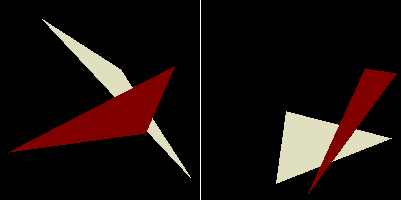

In [10]:
np.random.seed(18)
labels_ = [dummy_triangles(H, classes) for b in range(B)]
labels = np.stack(map(np.array, labels_)).astype(np.uint8)
pil_grid(labels_, 5, margin=1)

### Features

In [11]:
np.random.seed(57)
feats = np.zeros(labels.shape)
feats[labels == 0] = np.random.normal(-1, 2.5, size=feats.shape)[labels == 0]
feats[labels == 1] = np.random.normal(1, 2.5, size=feats.shape)[labels == 1]
feats[labels == 255] = np.random.normal(0, 5, size=feats.shape)[labels == 255]

In [12]:
sess = tf.InteractiveSession()

In [13]:
labels_tf = tf.placeholder(np.int64, shape=(None, H, W), name='labels')
feats_tf = tf.placeholder(np.float32, shape=(None, H, W), name='features')

In [14]:
feed_dict = {labels_tf: labels, 
             feats_tf: feats}

### Model

In [15]:
class Model:
    '''
    Simple linear model
    '''
    
    def __init__(self, feats):
        self.feats = feats
        self.scores
        self.predict

    @define_scope
    def scores(self):
        x = self.feats
        bias = tf.Variable(0., x.dtype, name="bias")
        return tf.add(x, bias, name="scores")
    
    @define_scope
    def probas(self):
        return tf.nn.sigmoid(self.scores)
    
    @define_scope
    def predict(self):
        return tf.greater_equal(self.scores, 0, name="predict")

In [16]:
m = Model(feats_tf)

In [17]:
sess.run(tf.global_variables_initializer())

## Lovász-Hinge value

In [18]:
loss = L.lovasz_hinge(m.scores, labels_tf, ignore=IGNORE, per_image=True)

In [19]:
loss.eval(feed_dict)

3.4664207

#### Gradient w.r.t. bias

In [20]:
tf.gradients(loss, tf.trainable_variables()[0])[0].eval(feed_dict)

W0226 18:10:16.500215 139827989141312 deprecation.py:323] From /esat/visicsdata/mberman/miniconda2/envs/lamlearn/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


0.57314444

### PyTorch reference

should give the same results...

In [21]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn

class ModelPytorch(nn.Module):
    def __init__(self):
        super(ModelPytorch, self).__init__()
        self.bias = nn.Parameter(torch.Tensor([0]))
    
    def forward(self, x):
        return x + self.bias

m_torch = ModelPytorch()
out = m_torch(Variable(torch.from_numpy(feats.astype(np.float32))))
loss_torch = L_pytorch.lovasz_hinge(out, torch.from_numpy(labels), ignore=IGNORE, per_image=True)

In [22]:
loss_torch.data.numpy().item()

3.4664201736450195

#### Gradient w.r.t. bias

In [23]:
loss_torch.backward()

In [24]:
m_torch.bias.grad.data.numpy().item()

0.5731444358825684

## Lovász-Sigmoid value

In [25]:
loss = L.lovasz_softmax(m.probas, labels_tf, classes=[1], ignore=IGNORE, per_image=True)

In [26]:
loss.eval(feed_dict)

0.80367076

In [31]:
tf.gradients(loss, tf.trainable_variables()[0])[0].eval(feed_dict)

0.032584023

### PyTorch reference

In [27]:
sigmoid_out = torch.sigmoid(out)

In [28]:
loss_torch = L_pytorch.lovasz_softmax(sigmoid_out, torch.from_numpy(labels), classes=[1], ignore=IGNORE, per_image=True)
loss_torch

tensor(0.8037, grad_fn=<DivBackward0>)

In [29]:
m_torch.bias.grad.data.fill_(0)
loss_torch.backward()

In [30]:
m_torch.bias.grad.data.numpy().item()

0.03258401155471802